# 前置作業

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
# from torch.utils import data
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import load_model
import torch
import torch.nn as nn
import torch.optim as optim
import random

In [ ]:
data = pd.read_csv('combined_data.csv')

# 數據準備


In [ ]:
# 分割訓練集和測試集
# 根據Material和Condition進行數據劃分
# train_data = data[~((data['Material'] == 13) & (data['Condition'] == 'd'))]
train_data = data[~((data['Material'] == 13))]
test_data = data[(data['Material'] == 13) & (data['Condition'] == 'c')]

# 選擇 validation set & 訓練集排除這部分數據
validation_data = data[(data['Material'] == 13) & (data['Condition'] == 'b')]
# train_data = train_data[~((train_data['Material'] == 5) & (train_data['Condition'] == 'b'))]
# 檢查劃分結果
print(f"訓練集樣本數: {train_data.shape[0]}")
print(f"驗證集樣本數: {validation_data.shape[0]}")
print(f"測試集樣本數: {test_data.shape[0]}")

訓練集樣本數: 192000
驗證集樣本數: 4000
測試集樣本數: 4000


In [ ]:
# 需要標準化的特徵列
feature_columns = [f'y{i:02}' for i in range(1, 11)]

# 使用訓練集來fit標準化
scaler = MinMaxScaler()

# 對訓練集標準化
train_data[feature_columns] = scaler.fit_transform(train_data[feature_columns])

# 對驗證集使用相同的縮放進行標準化
validation_data[feature_columns] = scaler.transform(validation_data[feature_columns])

# 對測試集使用相同的縮放進行標準化
test_data[feature_columns] = scaler.transform(test_data[feature_columns])

C:\Users\sean\AppData\Local\Temp\ipykernel_20320\3500195941.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[feature_columns] = scaler.fit_transform(train_data[feature_columns])
C:\Users\sean\AppData\Local\Temp\ipykernel_20320\3500195941.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_data[feature_columns] = scaler.transform(validation_data[feature_columns])
C:\Users\sean\AppData\Local\Temp\ipykernel_20320\3500195941.py:14: SettingWithCopyWarning: 
A value is trying to be set o

In [ ]:
def create_sequences(data, feature_columns, window_size_in=50, window_size_out=25):
    sequences = []
    targets = []

    materials = data['Material'].unique()
    conditions = data['Condition'].unique()

    for material in materials:
        for condition in conditions:
            material_condition_data = data[(data['Material'] == material) & (data['Condition'] == condition)]

            # 獲取特徵數據
            features = material_condition_data[feature_columns].values

            # 切割序列
            for i in range(len(features) - window_size_in - window_size_out + 1):
                seq_in = features[i:i+window_size_in]
                seq_out = features[i+window_size_in:i+window_size_in+window_size_out]
                sequences.append(seq_in)
                targets.append(seq_out)

    return np.array(sequences), np.array(targets)

# 創建訓練集的 sequence windows
X_train, y_train = create_sequences(train_data, feature_columns)

# 創建測試集的 sequence windows
X_test, y_test = create_sequences(test_data, feature_columns)

# 創建 validation set 的 sequence windows
X_val, y_val = create_sequences(validation_data, feature_columns)

print(f"訓練集序列數: {X_train.shape[0]}")
print(f"測試集序列數: {X_val.shape[0]}")
print(f"測試集序列數: {X_test.shape[0]}")

訓練集序列數: 188448
測試集序列數: 3926
測試集序列數: 3926


In [ ]:
# 將數據轉換為 Tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# 創建 TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# 創建 DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 檢查 Dataloader
print(f"訓練集批次數: {len(train_loader)}")
print(f"測試集批次數: {len(test_loader)}")
print(f"驗證集批次數: {len(val_loader)}")

訓練集批次數: 2945
測試集批次數: 62
驗證集批次數: 62


# Model

In [ ]:
class LSTMSeq2Seq(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(LSTMSeq2Seq, self).__init__()

        # 兩層的編碼器 LSTM
        self.encoder_lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # 單層的解碼器 LSTM
        self.decoder_lstm = nn.LSTM(output_size, hidden_size, 1, batch_first=True)

        # Output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_inputs, decoder_inputs, teacher_forcing_ratio=0.5):
        # Encoder forward pass
        _, (hidden, cell) = self.encoder_lstm(encoder_inputs)

        # Teacher forcing: 使用teacher forcing的比例
        use_teacher_forcing = True if torch.rand(1).item() < teacher_forcing_ratio else False

        # Decoder forward pass
        decoder_outputs = []
        decoder_input = decoder_inputs[:, 0, :].unsqueeze(1)  # 初始化解碼器的輸入

        for t in range(decoder_inputs.size(1)):
            output, (hidden, cell) = self.decoder_lstm(decoder_input, (hidden, cell))
            output = self.fc(output)  # Apply output layer

            decoder_outputs.append(output)

            # 下一個時間步的輸入
            if use_teacher_forcing:
                decoder_input = decoder_inputs[:, t, :].unsqueeze(1)  # 使用真實的輸入
            else:
                decoder_input = output  # 使用模型的預測作為下一個時間步的輸入

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        return decoder_outputs

In [ ]:
# 模型參數
input_size = 10  # 每個時間步的特徵數量
hidden_size = 100  # LSTM 隱藏層的單元數量
output_size = 10  # 每個時間步的輸出特徵
num_layers = 2  # Encoder LSTM 層數

# 創建模型
model = LSTMSeq2Seq(input_size, hidden_size, output_size, num_layers)

# 損失函數與優化器
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 模型摘要
print(model)

LSTMSeq2Seq(
  (encoder_lstm): LSTM(10, 100, batch_first=True)
  (decoder_lstm): LSTM(10, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=10, bias=True)
)


In [ ]:
# 定義 Early Stopping 機制
class EarlyStopping:
    def __init__(self, patience=10, delta=0):
        self.patience = patience  # 容忍的epoch數
        self.delta = delta  # 最小損失改善
        self.best_loss = None
        self.counter = 0
        self.early_stop = False
        self.best_weights = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_weights = model.state_dict()
        elif val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.best_weights = model.state_dict()
            self.counter = 0  # 每次有進步時重置計數器
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                model.load_state_dict(self.best_weights)  # 回復最佳權重

In [ ]:
def train_model(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=64, teacher_forcing_ratio=0.5, patience=10):
    early_stopping = EarlyStopping(patience=patience)  # 初始化 Early Stopping

    # 記錄每個 epoch 的損失
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for i in range(0, len(X_train), batch_size):
            X_batch = torch.tensor(X_train[i:i+batch_size], dtype=torch.float32)
            y_batch = torch.tensor(y_train[i:i+batch_size], dtype=torch.float32)

            optimizer.zero_grad()  # 重置梯度

            # 前向傳播
            output = model(X_batch, y_batch, teacher_forcing_ratio)

            # 計算損失
            loss = criterion(output, y_batch)
            loss.backward()  # 反向傳播

            optimizer.step()  # 更新參數

            epoch_loss += loss.item()

        train_loss = epoch_loss / len(X_train)
        train_losses.append(train_loss)  # 保存每個 epoch 的訓練損失
        print(f'Epoch {epoch+1}, Training Loss: {train_loss:.4f}')

        # 驗證集上的損失計算
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for i in range(0, len(X_val), batch_size):
                X_val_batch = torch.tensor(X_val[i:i+batch_size], dtype=torch.float32)
                y_val_batch = torch.tensor(y_val[i:i+batch_size], dtype=torch.float32)

                output_val = model(X_val_batch, y_val_batch, teacher_forcing_ratio=0.0)  # 驗證時不使用teacher forcing
                val_loss += criterion(output_val, y_val_batch).item()

        val_loss /= len(X_val)
        val_losses.append(val_loss)  # 保存每個 epoch 的驗證損失
        print(f'Validation Loss: {val_loss:.4f}')

        # 檢查 Early Stopping
        early_stopping(val_loss, model)

        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    # 返回訓練和驗證損失
    return train_losses, val_losses

# 開始訓練
train_losses, val_losses = train_model(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=64, teacher_forcing_ratio=0.5, patience=10)

Epoch 1, Training Loss: 0.0000
Validation Loss: 0.0000
Epoch 2, Training Loss: 0.0000
Validation Loss: 0.0000
Epoch 3, Training Loss: 0.0000
Validation Loss: 0.0000
Epoch 4, Training Loss: 0.0000
Validation Loss: 0.0000
Epoch 5, Training Loss: 0.0000
Validation Loss: 0.0000
Epoch 6, Training Loss: 0.0000
Validation Loss: 0.0000
Epoch 7, Training Loss: 0.0000
Validation Loss: 0.0000
Epoch 8, Training Loss: 0.0000
Validation Loss: 0.0000
Epoch 9, Training Loss: 0.0000
Validation Loss: 0.0000
Epoch 10, Training Loss: 0.0000
Validation Loss: 0.0000
Epoch 11, Training Loss: 0.0000
Validation Loss: 0.0000
Epoch 12, Training Loss: 0.0000
Validation Loss: 0.0000
Epoch 13, Training Loss: 0.0000
Validation Loss: 0.0000
Epoch 14, Training Loss: 0.0000
Validation Loss: 0.0000
Epoch 15, Training Loss: 0.0000
Validation Loss: 0.0000
Epoch 16, Training Loss: 0.0000
Validation Loss: 0.0000
Epoch 17, Training Loss: 0.0000
Validation Loss: 0.0000
Epoch 18, Training Loss: 0.0000
Validation Loss: 0.0000
E

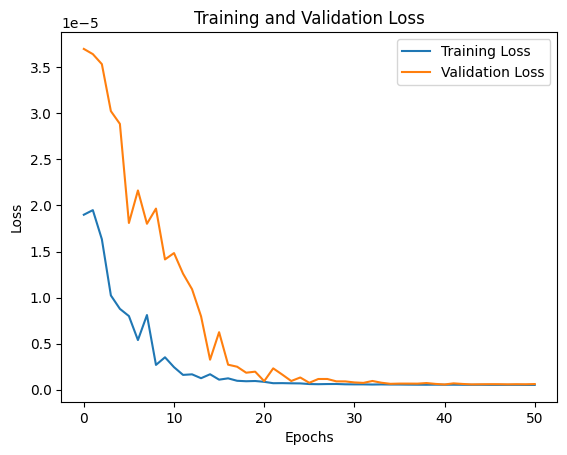

In [ ]:
# 繪製訓練損失和驗證損失
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 後處理

In [ ]:
torch.save(model, 'teacher_forcing_model.pt')

In [ ]:
model = load_model('LSTM_Seq2Seq第一版.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# PyTorch 版本的逐步預測函數 (修正過的版本)
def stepwise_prediction(model, initial_sequence, prediction_steps=3950, step_size=25):
    model.eval()  # 切換到評估模式
    predictions = []

    # 確保初始輸入為 tensor 並調整形狀
    current_input = torch.tensor(initial_sequence, dtype=torch.float32).unsqueeze(0)  # (1, 50, 10)

    # 記錄預測的總步數
    total_steps = prediction_steps // step_size

    # 逐步進行預測
    for _ in range(total_steps):
        with torch.no_grad():  # 不需要計算梯度，提升推理效率
            # 使用模型進行預測
            predicted = model(current_input, current_input[:, :, :], teacher_forcing_ratio=0.0)  # 不使用 Teacher Forcing
            predicted = predicted[:, -step_size:, :]  # 獲取最後 step_size 個時間步的預測結果
            predictions.append(predicted.detach().cpu().numpy())  # 將 tensor 轉為 numpy 並加入結果列表

        # 更新輸入，使用最後 25 筆預測結果更新輸入序列
        current_input = torch.cat((current_input[:, -25:, :], predicted), dim=1)[:, -50:, :]  # 保證保持 50 個時間步

    # 將所有預測結果合併為一個大的序列
    return np.concatenate(predictions, axis=1)

In [ ]:
# 使用測試集的初始數據進行逐步預測
initial_sequence = X_test_tensor[0]  # 測試集中的初始數據
predicted_sequence = stepwise_prediction(model, initial_sequence)

# 計算 MSE
true_sequence = test_data[feature_columns].values[-3950:]
predicted_sequence = predicted_sequence.reshape(-1, 10)

C:\Users\sean\AppData\Local\Temp\ipykernel_20320\773877440.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_input = torch.tensor(initial_sequence, dtype=torch.float32).unsqueeze(0)  # (1, 50, 10)


In [ ]:
mse = mean_squared_error(true_sequence, predicted_sequence)

In [ ]:
mse

0.0023225372741988008

In [ ]:
predicted_sequence_scaled = predicted_sequence.reshape(-1, 10)
predicted_sequence_unscaled = scaler.inverse_transform(predicted_sequence_scaled)
true_sequence_unscaled = scaler.inverse_transform(true_sequence)
model_mse_original_scale = mean_squared_error(true_sequence_unscaled , predicted_sequence_unscaled)
print(f"還原後的測試集均方誤差 (MSE): {model_mse_original_scale}")

還原後的測試集均方誤差 (MSE): 30930.855997406343


# 測試結果

In [ ]:
initial_sequence = X_test[0]
# 基於前 50 筆資料的平均值進行基線預測
baseline_prediction = np.mean(initial_sequence, axis=0)

# 將平均值複製來生成 3950 筆預測
baseline_sequence = np.tile(baseline_prediction, (3950, 1))

# 計算基線 MSE
baseline_mse = mean_squared_error(true_sequence, baseline_sequence)

print(f"基線 (前 50 筆均值) 的 MSE: {baseline_mse}")

基線 (前 50 筆均值) 的 MSE: 0.10496929027270967


In [ ]:
# 使用模型進行逐步預測，假設 initial_sequence 是前 50 筆的數據
initial_sequence = X_test[0]  # 測試集中的初始數據
predicted_sequence = stepwise_prediction(model, initial_sequence)

# 計算模型預測的 MSE
true_sequence = test_data[feature_columns].values[-3950:]  # 將真實值展開為 (3950, 10)
model_mse = mean_squared_error(true_sequence, predicted_sequence.reshape(-1, 10))

print(f"模型的 MSE: {model_mse}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

In [ ]:
predicted_sequence_scaled = predicted_sequence.reshape(-1, 10)
predicted_sequence_unscaled = scaler.inverse_transform(predicted_sequence_scaled)
true_sequence_unscaled = scaler.inverse_transform(true_sequence)
model_mse_original_scale = mean_squared_error(true_sequence_unscaled , predicted_sequence_unscaled)
print(f"還原後的測試集均方誤差 (MSE): {model_mse_original_scale}")

還原後的測試集均方誤差 (MSE): 222287.65195322092


In [ ]:
predicted_sequence_unscaled

array([[1025.6567  ,  635.8706  , 1544.3057  , ...,  628.78357 ,
         643.21576 ,  779.8312  ],
       [ 954.8589  ,  566.41736 , 1457.5021  , ...,  556.0328  ,
         546.92615 ,  738.74457 ],
       [ 952.7936  ,  582.3274  , 1447.1246  , ...,  595.3091  ,
         573.5616  ,  791.5039  ],
       ...,
       [ 103.662674,  100.07056 ,  104.92226 , ...,  114.93251 ,
         111.4126  ,  100.86907 ],
       [ 103.604034,  100.027565,  104.87072 , ...,  114.87404 ,
         111.35111 ,  100.82143 ],
       [ 103.544174,   99.9816  ,  104.819176, ...,  114.81507 ,
         111.289505,  100.77187 ]], dtype=float32)

In [ ]:
initial_sequence = X_test[0]
# 基於前 50 筆資料的平均值進行基線預測
baseline_prediction = np.mean(initial_sequence, axis=0)

# 將平均值複製來生成 3950 筆預測
baseline_sequence = np.tile(baseline_prediction, (3950, 1))
baseline_sequence_unscaled = scaler.inverse_transform(baseline_sequence)
# 計算基線 MSE
baseline_unscaled_mse = mean_squared_error(true_sequence_unscaled, baseline_sequence_unscaled)

print(f"還原後亂猜均方誤差 MSE: {baseline_unscaled_mse}")

還原後亂猜均方誤差 MSE: 997298.4656491021
